In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np
from utils import plot_validation_accuracy, plot_multi_curves


from tqdm import tqdm
from sklearn.svm import SVC

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset, random_split
from torchvision import datasets, transforms

In [4]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.append(parent_dir)

from utils import AddGaussianNoise, AddImpulseNoise

# Model Defintion: SmallCNN

A SGD classifer is not enough to get reliable insights on CIFAR-10 dataset so we will use a lightweight CNN. This will allow us to accurately estimate the influence of training order

In [5]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# MNIST Dataset (Vanilla Case)

## Data Loading

As MNIST consist of grayscale images, we can define 1 channel of size 28x28.

In [6]:
# Define the transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

# Download base datasets
base_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
base_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract tensors from base_train
X_all = torch.stack([base_train[i][0] for i in range(len(base_train))])
y_all = torch.tensor([base_train[i][1] for i in range(len(base_train))])

# Split into train and validation
val_split = 0.1
n_total = len(X_all)
n_val = int(n_total * val_split)
n_train = n_total - n_val

# Use torch random_split
train_data, val_data = random_split(list(zip(X_all, y_all)), [n_train, n_val])

# Convert splits back to TensorDataset
X_train, y_train = zip(*train_data)
X_val, y_val     = zip(*val_data)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)
X_val   = torch.stack(X_val)
y_val   = torch.tensor(y_val)

# Process test set
X_test = torch.stack([base_test[i][0] for i in range(len(base_test))])
y_test = torch.tensor([base_test[i][1] for i in range(len(base_test))])

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Optional: print dataset sizes
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 54000, Val: 6000, Test: 10000


## Analysis

We will investigate convergence time using a threshold epsilon (ε) based on validation accuracy. We found in litterature, ε = 1e-3 (0.001) is often used as a practical threshold in early stopping. This means if validation accuracy improves by less than 0.1% between epochs, we consider the model has plateaued.

In [7]:
epsilon = 1e-3

### (0) Base Case

Let's try as the Vanilla Base Case: Train on the entire dataset using uniform random shuffling for each epoch.

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 2

for epoch in range(n_epochs):
    # TRAINING
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Using device: cpu
Epoch 1/2 - Train Loss: 0.1393 - Val Accuracy: 0.9777
Epoch 2/2 - Train Loss: 0.0445 - Val Accuracy: 0.9880
Test Accuracy: 0.9882


### (1) Curriculum Learning

#### Pre-analysis

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the centroid of each class.

In [9]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

#### Analysis

In [10]:
X_train_flat = X_train.view(len(X_train), -1).numpy()

centroids = np.zeros((10, X_train_flat.shape[1]))
for i in range(10):
    centroids[i] = X_train_flat[y_train == i].mean(axis=0)

In [11]:
stage_accs_MNIST_curr_learn = []
num_examples_MNIST_curr_learn = []

# Compute difficulty score
difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)

# Normalize difficulties to [0, 1]
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

# Sort indices by difficulty
sorted_indices = np.argsort(difficulties)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

# Define curriculum stages as % of dataset (in increasing difficulty)
phases = np.linspace(0.1, 1.0, num_stages)

previous_n = 0  # Start index for slicing

for stage, phase in enumerate(phases):
    current_n = int(phase * len(sorted_indices))
    selected_idx = sorted_indices[previous_n:current_n]
    previous_n = current_n  # Update for next stage
    
    print(f"\nStage {stage+1}/{num_stages}: Using {len(selected_idx)} new examples")

    # Prepare current stage dataset
    X_stage = X_train[selected_idx]
    y_stage = y_train[selected_idx]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset):.4f} - Train Accuracy: {acc:.4f} - Val Accuracy: {val_accuracy:.4f}")
        
        stage_accs_MNIST_curr_learn.append(val_accuracy)
        num_examples_MNIST_curr_learn.append(current_n)

# Final test accuracy

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using 5400 new examples
    Epoch 1/1 - Train Loss: 0.1590 - Train Accuracy: 0.9700 - Val Accuracy: 0.5022

Stage 2/5: Using 12150 new examples
    Epoch 1/1 - Train Loss: 0.1108 - Train Accuracy: 0.9714 - Val Accuracy: 0.8678

Stage 3/5: Using 12150 new examples
    Epoch 1/1 - Train Loss: 0.0800 - Train Accuracy: 0.9736 - Val Accuracy: 0.9262

Stage 4/5: Using 12150 new examples
    Epoch 1/1 - Train Loss: 0.0988 - Train Accuracy: 0.9683 - Val Accuracy: 0.9555

Stage 5/5: Using 12150 new examples
    Epoch 1/1 - Train Loss: 0.1607 - Train Accuracy: 0.9507 - Val Accuracy: 0.9458

Final Test Accuracy: 0.9481


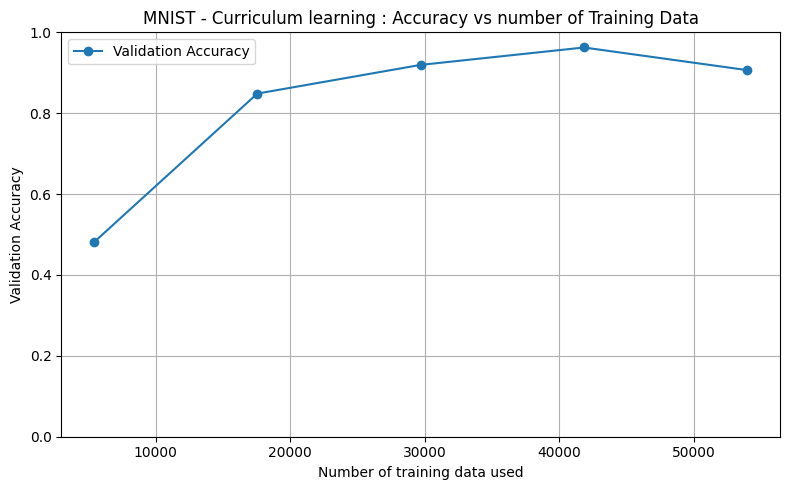

In [12]:
plot_validation_accuracy(
    num_examples_MNIST_curr_learn,
    stage_accs_MNIST_curr_learn,
    x_label="Number of training data used",
    title="MNIST - Curriculum learning : Accuracy vs number of Training Data")

### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:

• learn from easier samples first (based on current loss)

• adaptively expand its training set to include harder samples as it becomes more confident

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
samples_per_epoch = len(X_train)

seen_mask = torch.zeros(len(X_train), dtype=torch.bool)

for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        unseen_indices = (~seen_mask).nonzero(as_tuple=True)[0]
        unseen_loader = DataLoader(TensorDataset(X_train[unseen_indices], y_train[unseen_indices]),
                                   batch_size=batch_size, shuffle=False)

        all_losses = []
        for images, labels in unseen_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)
            all_losses.append(losses.cpu())

        all_losses = torch.cat(all_losses)

    
    k = min(samples_per_epoch, len(unseen_indices))
    selected_in_unseen = torch.topk(-all_losses, k).indices
    selected_indices = unseen_indices[selected_in_unseen]

    seen_mask[selected_indices] = True

    print(f"Epoch {epoch+1}: selected {len(selected_indices)} new samples (total seen: {seen_mask.sum().item()}/{len(X_train)})")

    train_loader = DataLoader(TensorDataset(X_train[selected_indices], y_train[selected_indices]),
                              batch_size=batch_size, shuffle=True)

    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(labels)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_loader.dataset)
    print(f"  Train Loss: {total_loss / len(train_loader.dataset):.4f}, Acc: {acc:.4f}")
    
print("Training complete.")

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

This poor accuracy can be explained because of the cumulative nature of SPL

### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,75 (in other words the top 25%).

In [12]:
accs_MNIST_H_ex_mining = []
epochs_list_MINST_H_ex_mining = []

difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

hard_mask = difficulties >= 0.75
hard_indices = np.where(hard_mask)[0] # we do not shuffle the indices to train on increasingly difficult samples (adapted CL idea)
print(f"Selected {len(hard_indices)} hard examples out of {len(difficulties)} total")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10

X_hard = X_train[hard_indices]
y_hard = y_train[hard_indices]

train_dataset = TensorDataset(X_hard, y_hard)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               outputs = model(images)
               predicted = outputs.argmax(dim=1)
               val_correct += (predicted == labels).sum().item()
               val_total += labels.size(0)

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

    accs_MNIST_H_ex_mining.append(acc)
    epochs_list_MINST_H_ex_mining.append(epoch + 1)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Selected 309 hard examples out of 54000 total
Epoch 1/10 - Loss: 2.1231, Acc: 0.2104
Epoch 2/10 - Loss: 1.6686, Acc: 0.4498
Epoch 3/10 - Loss: 1.2616, Acc: 0.5663
Epoch 4/10 - Loss: 0.9518, Acc: 0.6828
Epoch 5/10 - Loss: 0.7973, Acc: 0.6990
Epoch 6/10 - Loss: 0.5945, Acc: 0.7896
Epoch 7/10 - Loss: 0.4821, Acc: 0.8350
Epoch 8/10 - Loss: 0.3766, Acc: 0.8641
Epoch 9/10 - Loss: 0.2945, Acc: 0.9223
Epoch 10/10 - Loss: 0.2315, Acc: 0.9288

Final Test Accuracy: 0.3961


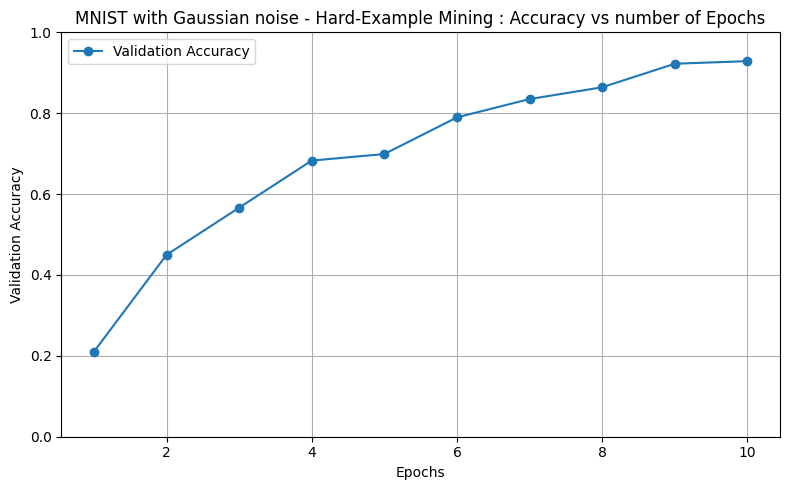

In [13]:
plot_validation_accuracy(
    epochs_list_MINST_H_ex_mining,
    accs_MNIST_H_ex_mining,
    x_label="Epochs",
    title="MNIST with Gaussian noise - Hard-Example Mining : Accuracy vs number of Epochs")

### (4) Reverse Curriculum Learning

We are implementing **Reverse Curriculum Learning (RCL)** where the model starts learning from easier goals that are close to the target and gradually works backwards to more challenging starting states.

In [14]:
stage_accs_MNIST_Rev_Curr_learn = []
num_examples_MNIST_Rev_Curr_learn = []

difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

sorted_indices = np.argsort(difficulties)[::-1].copy()  # reverse order for hardest first

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

phases = np.linspace(0.1, 1.0, num_stages)

previous_n = 0

for stage, phase in enumerate(phases):
    current_n = int(phase * len(sorted_indices))
    selected_idx = sorted_indices[previous_n:current_n]
    previous_n = current_n
    
    print(f"\nStage {stage+1}/{num_stages}: Using {len(selected_idx)} new hard→easy examples")

    X_stage = X_train[selected_idx]
    y_stage = y_train[selected_idx]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

# VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               outputs = model(images)
               predicted = outputs.argmax(dim=1)
               val_correct += (predicted == labels).sum().item()
               val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Rev_Curr_learn.append(acc)
        num_examples_MNIST_Rev_Curr_learn.append(current_n)


model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Stage 1/5: Using 5400 new hard→easy examples
  Epoch 1/1 - Loss: 0.8331, Acc: 0.7281

Stage 2/5: Using 12150 new hard→easy examples
  Epoch 1/1 - Loss: 0.1388, Acc: 0.9560

Stage 3/5: Using 12150 new hard→easy examples
  Epoch 1/1 - Loss: 0.0646, Acc: 0.9801

Stage 4/5: Using 12150 new hard→easy examples
  Epoch 1/1 - Loss: 0.0278, Acc: 0.9897

Stage 5/5: Using 12150 new hard→easy examples
  Epoch 1/1 - Loss: 0.0056, Acc: 0.9983

Final Test Accuracy: 0.9579


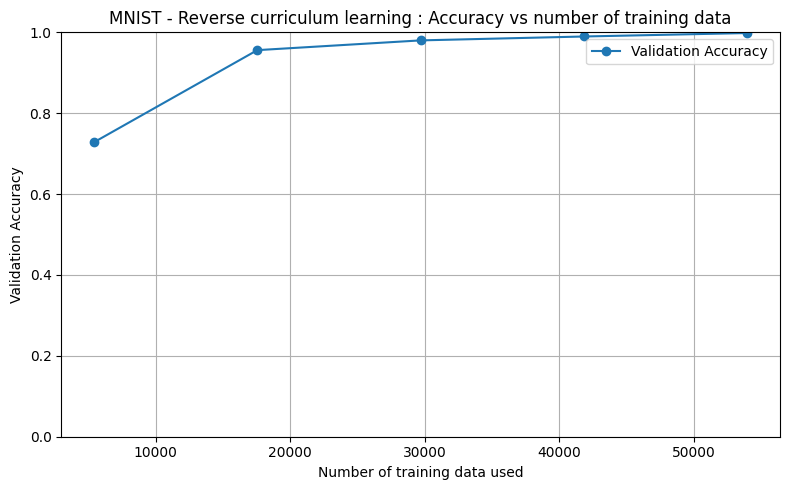

In [15]:
plot_validation_accuracy(
    num_examples_MNIST_Rev_Curr_learn,
    stage_accs_MNIST_Rev_Curr_learn,
    x_label="Number of training data used",
    title="MNIST - Reverse curriculum learning : Accuracy vs number of training data")

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [16]:
stage_accs_MNIST_Monte_Carlo = []
num_examples_MNIST_Monte_Carlo = []
total_seen = 0

difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5
samples_per_stage = int(len(X_train) / num_stages)

num_bins = num_stages
bin_edges = np.linspace(0, 1, num_bins + 1)
bins = [[] for _ in range(num_bins)]

for idx, score in enumerate(difficulties):
    for b in range(num_bins):
        if bin_edges[b] <= score < bin_edges[b + 1] or (b == num_bins - 1 and score == 1.0):
            bins[b].append(idx)
            break

for b in bins:
    np.random.shuffle(b)

seen_indices = set()
num_seen = 0

for stage in range(num_stages):
    
    current_sample_size = len(selected_idx)  
    total_seen += current_sample_size    

    stage_indices = []

    for b in bins:
        take_n = min(samples_per_stage // num_bins, len(b))
        selected = [i for i in b if i not in seen_indices][:take_n]
        seen_indices.update(selected)
        stage_indices.extend(selected)

    np.random.shuffle(stage_indices)

    X_stage = X_train[stage_indices]
    y_stage = y_train[stage_indices]
    num_seen += len(X_stage)

    print(f"\nStage {stage+1}/{num_stages}: Sampling {len(X_stage)} data points from all difficulty strata ({num_seen}/{len(X_train)})")

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

    # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total


        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")
        stage_accs_MNIST_Monte_Carlo.append(acc)
        num_examples_MNIST_Monte_Carlo.append(total_seen)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")




Stage 1/5: Sampling 8752 data points from all difficulty strata (8752/54000)
  Epoch 1/1 - Loss: 0.5265, Acc: 0.8340

Stage 2/5: Sampling 7368 data points from all difficulty strata (16120/54000)
  Epoch 1/1 - Loss: 0.1160, Acc: 0.9654

Stage 3/5: Sampling 4458 data points from all difficulty strata (20578/54000)
  Epoch 1/1 - Loss: 0.1043, Acc: 0.9681

Stage 4/5: Sampling 4320 data points from all difficulty strata (24898/54000)
  Epoch 1/1 - Loss: 0.0879, Acc: 0.9755

Stage 5/5: Sampling 4320 data points from all difficulty strata (29218/54000)
  Epoch 1/1 - Loss: 0.0788, Acc: 0.9738

Final Test Accuracy: 0.9813


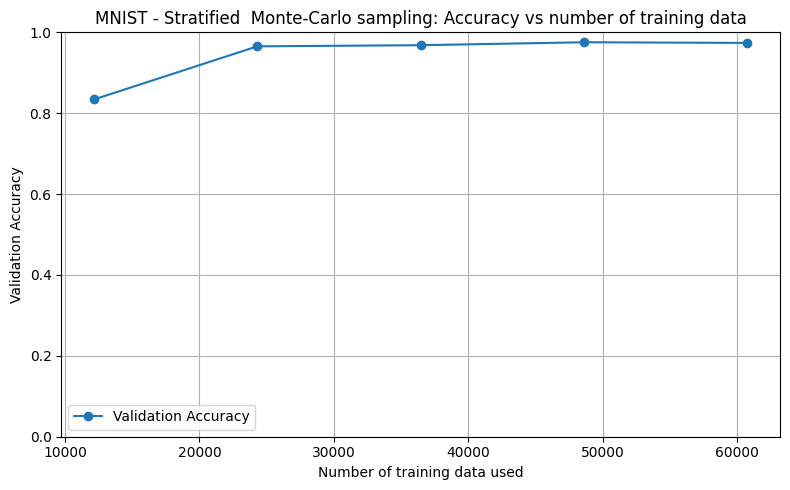

In [17]:
plot_validation_accuracy(
    num_examples_MNIST_Monte_Carlo,
    stage_accs_MNIST_Monte_Carlo,
    x_label="Number of training data used",
    title="MNIST - Stratified  Monte-Carlo sampling: Accuracy vs number of training data")

# MNIST Dataset with Gaussian Noise

## Data Loading

We initialize a range of increasing difficulty. 
- 0.0: no noise — easiest samples
- 0.4: very noisy — hardest samples
- 0.5+ usually makes MNIST unreadable

In [18]:
# Load base MNIST (no transform)
base_train = datasets.MNIST(root='./data', train=True, download=True)
base_test = datasets.MNIST(root='./data', train=False, download=True)

full_data = torch.cat([base_train.data, base_test.data], dim=0).float() / 255.0
full_targets = torch.cat([base_train.targets, base_test.targets], dim=0)

# Expand with noise
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]
augmented_data, augmented_targets, noise_labels = [], [], []

for level in noise_levels:
    noise = torch.randn_like(full_data) * level
    noisy_data = full_data + noise
    noisy_data = torch.clamp(noisy_data, 0.0, 1.0)

    augmented_data.append(noisy_data)
    augmented_targets.append(full_targets)
    noise_labels.append(torch.full_like(full_targets, level))

# Combine everything
augmented_data = torch.cat(augmented_data, dim=0).unsqueeze(1)  # (N*L, 1, 28, 28)
augmented_targets = torch.cat(augmented_targets, dim=0)
noise_labels = torch.cat(noise_labels, dim=0)

# Final dataset
augmented_dataset = TensorDataset(augmented_data, augmented_targets, noise_labels)

In [19]:
N_train = len(base_train)  # 60000
N_test = len(base_test)    # 10000

samples_per_level = N_train + N_test

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for i in range(len(noise_levels)):
    start = i * samples_per_level
    end = start + samples_per_level

    X_level = augmented_data[start:end]
    y_level = augmented_targets[start:end]

    X_train_list.append(X_level[:N_train])
    y_train_list.append(y_level[:N_train])
    X_test_list.append(X_level[N_train:])
    y_test_list.append(y_level[N_train:])

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: torch.Size([300000, 1, 28, 28]), y_train: torch.Size([300000])
X_test: torch.Size([50000, 1, 28, 28]), y_test: torch.Size([50000])


In [20]:
noise_levels_train_list = []

for i, level in enumerate(noise_levels):
    num_train_samples = N_train
    noise_level_tensor = torch.full((num_train_samples,), fill_value=i)
    
    noise_levels_train_list.append(noise_level_tensor)

noise_levels_train = torch.cat(noise_levels_train_list, dim=0)

print(f"noise_levels_train shape: {noise_levels_train.shape}")


noise_levels_train shape: torch.Size([300000])


## Analysis

### (0) Base Case

In [21]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # random sampling baseline
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f}, Train Acc: {train_acc:.4f}")

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/1 - Train Loss: 0.0840, Train Acc: 0.9741
Test Accuracy: 0.9858


### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [22]:
stage_accs_MNIST_Gaussian_cum_curr_learn = []
num_examples_MNIST_Gaussian_cum_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels <= {stage}")
    
    stage_mask = noise_levels_train <= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

    # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Gaussian_cum_curr_learn.append(acc)
        num_examples_MNIST_Gaussian_cum_curr_learn.append(np.sum([len(X_train[noise_levels_train <= s]) for s in range(stage+1)]))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise levels <= 0
  Epoch 1/1 - Loss: 0.1842, Acc: 0.9429

Stage 2/5: Using noise levels <= 1
  Epoch 1/1 - Loss: 0.0420, Acc: 0.9870

Stage 3/5: Using noise levels <= 2
  Epoch 1/1 - Loss: 0.0225, Acc: 0.9929

Stage 4/5: Using noise levels <= 3
  Epoch 1/1 - Loss: 0.0162, Acc: 0.9946

Stage 5/5: Using noise levels <= 4
  Epoch 1/1 - Loss: 0.0177, Acc: 0.9940

Final Test Accuracy: 0.9873


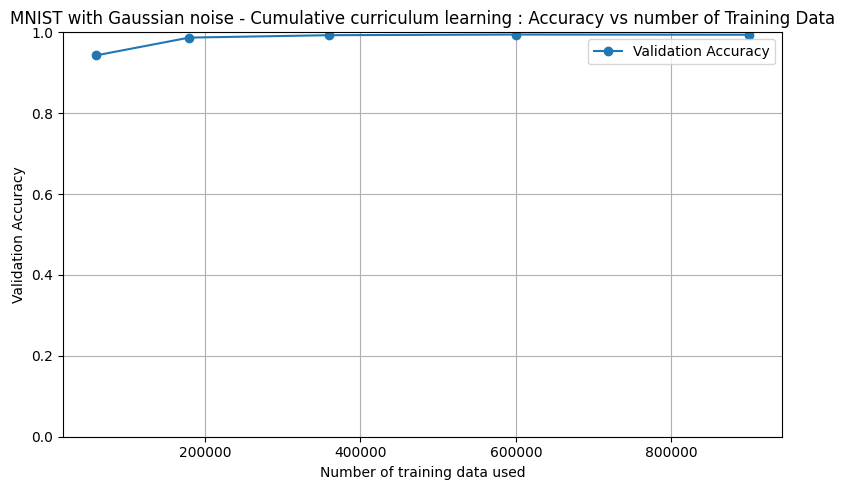

In [23]:
plot_validation_accuracy(
    num_examples_MNIST_Gaussian_cum_curr_learn,
    stage_accs_MNIST_Gaussian_cum_curr_learn,
    x_label="Number of training data used",
    title="MNIST with Gaussian noise - Cumulative curriculum learning : Accuracy vs number of Training Data")

#### (1.2) Strict Curriculum Learning

In [24]:
stage_accs_MNIST_Gaussian_strict_curr_learn = []
noise_levels_MNIST_Gaussian_strict_curr_learn = []
num_examples_MNIST_Gaussian_strict_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

    # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Gaussian_strict_curr_learn.append(acc)
        noise_levels_MNIST_Gaussian_strict_curr_learn.append(stage)
        num_examples_MNIST_Gaussian_strict_curr_learn.append(len(X_stage))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.1812, Acc: 0.9449

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0535, Acc: 0.9834

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0439, Acc: 0.9858

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.0472, Acc: 0.9848

Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.0638, Acc: 0.9793

Final Test Accuracy: 0.9886


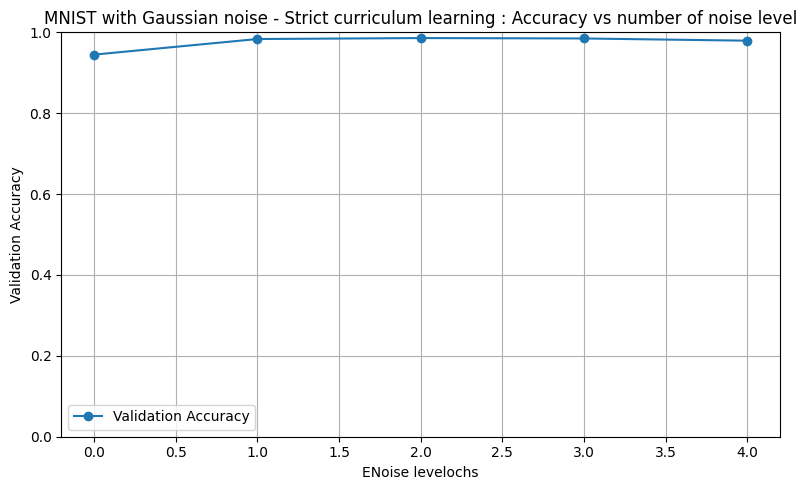

In [25]:
plot_validation_accuracy(
    noise_levels_MNIST_Gaussian_strict_curr_learn,
    stage_accs_MNIST_Gaussian_strict_curr_learn,
    x_label="ENoise levelochs",
    title="MNIST with Gaussian noise - Strict curriculum learning : Accuracy vs number of noise level")

### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

Because our objective is to see the influence of order on the training, we will stop training once the model saw the entire dataset. To be fair with the other techniques where they see the data only once.

In [27]:
train_accs_MNIST_Gaussian_Self_Paced = []
epochs_list_MNIST_Gaussian_Self_Paced = []
num_selected_MNIST_Gaussian_Self_Paced = []
lambda_values_MNIST_Gaussian_Self_Paced = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10
initial_lambda = 2.25  # initial difficulty threshold
lambda_increment = 2  # increase per epoch

full_train_dataset = TensorDataset(X_train, y_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.eval()
    all_losses = []

    with torch.no_grad():
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)
            all_losses.append(losses.cpu())

    all_losses = torch.cat(all_losses)
    print(torch.min(all_losses))
    print(torch.max(all_losses))

    lambda_threshold = initial_lambda + epoch * lambda_increment

    selected_indices = (all_losses <= lambda_threshold).nonzero(as_tuple=True)[0]

    if len(selected_indices) == 0:
        print(f"Epoch {epoch+1}: No samples selected for training (lambda={lambda_threshold:.3f}), stopping early.")
        break

    print(f"Epoch {epoch+1}: lambda={lambda_threshold:.3f}, selected {len(selected_indices)}/{len(X_train)} samples")

    train_subset = TensorDataset(X_train[selected_indices], y_train[selected_indices])
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_subset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total

    print(f"  Training Loss: {total_loss/len(train_subset):.4f}, Accuracy: {acc:.4f}")
    
    train_accs_MNIST_Gaussian_Self_Paced.append(acc)
    epochs_list_MNIST_Gaussian_Self_Paced.append(epoch + 1)
    num_selected_MNIST_Gaussian_Self_Paced.append(len(selected_indices))
    lambda_values_MNIST_Gaussian_Self_Paced.append(lambda_threshold)

    if len(selected_indices) == len(X_train):
        print(f"  All samples were selected, stopping early.")
        break

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


tensor(2.1841)
tensor(2.4704)
Epoch 1: lambda=2.250, selected 91782/300000 samples
  Training Loss: 0.0925, Accuracy: 0.9687
tensor(-0.)
tensor(38.8030)
Epoch 2: lambda=4.250, selected 118263/300000 samples
  Training Loss: 0.0214, Accuracy: 0.9923
tensor(-0.)
tensor(52.3465)
Epoch 3: lambda=6.250, selected 118365/300000 samples
  Training Loss: 0.0129, Accuracy: 0.9958
tensor(-0.)
tensor(72.7529)
Epoch 4: lambda=8.250, selected 142260/300000 samples
  Training Loss: 0.0244, Accuracy: 0.9924
tensor(-0.)
tensor(79.3252)
Epoch 5: lambda=10.250, selected 283230/300000 samples
  Training Loss: 0.0235, Accuracy: 0.9919
tensor(-0.)
tensor(44.1742)
Epoch 6: lambda=12.250, selected 299609/300000 samples
  Training Loss: 0.0182, Accuracy: 0.9940
tensor(-0.)
tensor(34.9849)
Epoch 7: lambda=14.250, selected 299986/300000 samples
  Training Loss: 0.0107, Accuracy: 0.9966
tensor(-0.)
tensor(45.3656)
Epoch 8: lambda=16.250, selected 299995/300000 samples
  Training Loss: 0.0077, Accuracy: 0.9974
ten

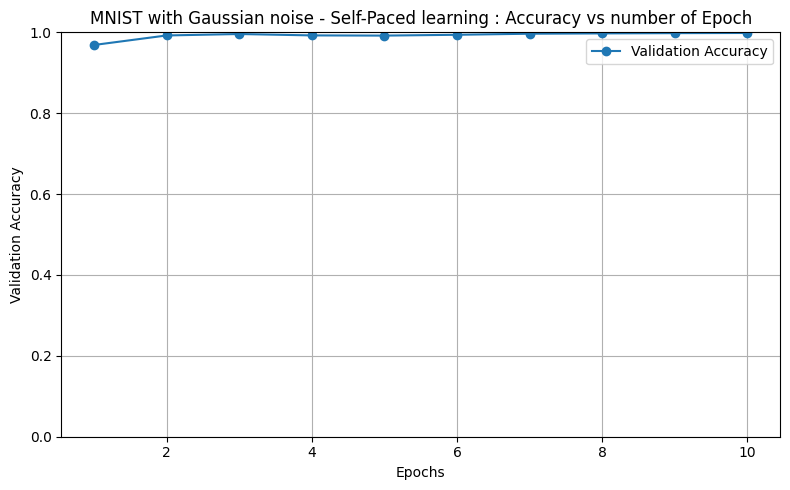

In [28]:
plot_validation_accuracy(
    epochs_list_MNIST_Gaussian_Self_Paced,
    train_accs_MNIST_Gaussian_Self_Paced,
    x_label="Epochs",
    title="MNIST with Gaussian noise - Self-Paced learning : Accuracy vs number of Epoch")


An idea could be to combine the difficulty scores from the noise levels with the increments in SLP:


**Option A: Use Noise Difficulty as a Prior or Weight for Lambda Threshold**

- Adjust the SPL threshold (`λ`) for each sample by incorporating its noise difficulty:

\[
\lambda_i = \lambda_{\text{base}} + \alpha \times \text{noise\_level}_i
\]

- Samples with higher noise difficulty require a higher loss to be included, effectively entering the curriculum later.

**Option B: Use Noise Difficulty for Initial Sample Filtering**

- Start SPL training using only samples with noise difficulty below a certain threshold (e.g., noise_level ≤ 0.2).
- Gradually expand the training set to include samples with higher noise difficulty as training progresses.

**Option C: Weighted Loss or Thresholding by Noise Difficulty Quantiles**

- Group samples by their noise difficulty levels.
- Compute separate SPL loss thresholds for each noise group.
- Allow lower thresholds (easier inclusion) for low-noise groups and higher thresholds for high-noise groups.
- This respects both the *a priori* noise difficulty and the *dynamic* training loss.

### (3) Hard-Example Mining

In [29]:
train_accs_MNIST_Gaussian_H_Ex = []
epochs_list_MNIST_Gaussian_H_Ex = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 5

# Define what "hard" means: top 1 or 2 noise levels (e.g., 0.3 and 0.4)
# If noise_levels_train goes from 0 to 4 (for noise 0.0 to 0.4), we can take levels >= 3
hard_mask = noise_levels_train >= 3


X_hard = X_train[hard_mask]
y_hard = y_train[hard_mask]
print(f"Selected {len(X_hard)} hard examples out of {len(X_train)}")

hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               outputs = model(images)
               predicted = outputs.argmax(dim=1)
               val_correct += (predicted == labels).sum().item()
               val_total += labels.size(0)

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(hard_dataset):.4f}, Accuracy: {acc:.4f}")

    train_accs_MNIST_Gaussian_H_Ex.append(acc)
    epochs_list_MNIST_Gaussian_H_Ex.append(epoch + 1)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Selected 120000 hard examples out of 300000
Epoch 1/5 - Loss: 0.2056, Accuracy: 0.9364
Epoch 2/5 - Loss: 0.0641, Accuracy: 0.9797
Epoch 3/5 - Loss: 0.0431, Accuracy: 0.9861
Epoch 4/5 - Loss: 0.0317, Accuracy: 0.9894
Epoch 5/5 - Loss: 0.0235, Accuracy: 0.9920

Final Test Accuracy: 0.9840


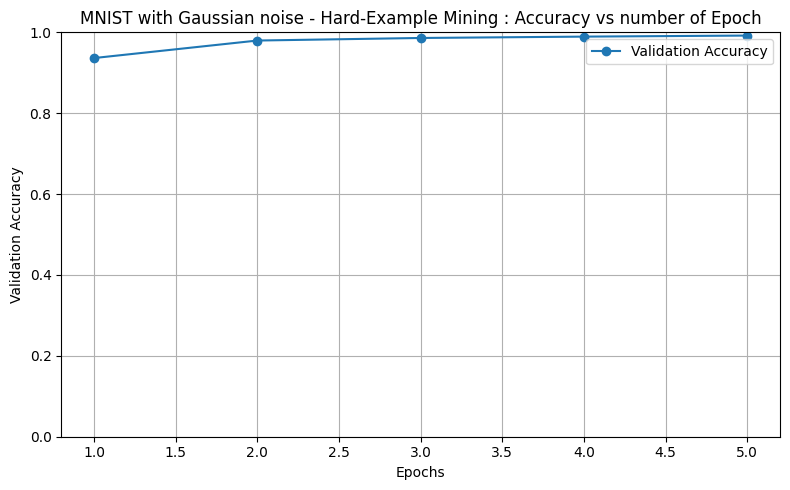

In [30]:
plot_validation_accuracy(
    epochs_list_MNIST_Gaussian_H_Ex,
    train_accs_MNIST_Gaussian_H_Ex,
    x_label="Epochs",
    title="MNIST with Gaussian noise - Hard-Example Mining : Accuracy vs number of Epoch")

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [31]:
stage_accs_MNIST_gaussian_cum_rev_curr_learn = []
min_noise_levels_MNIST_gaussian_cum_rev_curr_learn= []
num_examples_MNIST_gaussian_cum_rev_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1 
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels >= {stage}")
    
    stage_mask = noise_levels_train >= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total



        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_gaussian_cum_rev_curr_learn.append(acc)
        min_noise_levels_MNIST_gaussian_cum_rev_curr_learn.append(stage)
        num_examples_MNIST_gaussian_cum_rev_curr_learn.append(len(X_stage))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise levels >= 4
  Epoch 1/1 - Loss: 0.3583, Acc: 0.8866

Stage 4/5: Using noise levels >= 3
  Epoch 1/1 - Loss: 0.0890, Acc: 0.9724

Stage 3/5: Using noise levels >= 2
  Epoch 1/1 - Loss: 0.0490, Acc: 0.9842

Stage 2/5: Using noise levels >= 1
  Epoch 1/1 - Loss: 0.0302, Acc: 0.9898

Stage 1/5: Using noise levels >= 0
  Epoch 1/1 - Loss: 0.0184, Acc: 0.9938

Final Test Accuracy: 0.9866


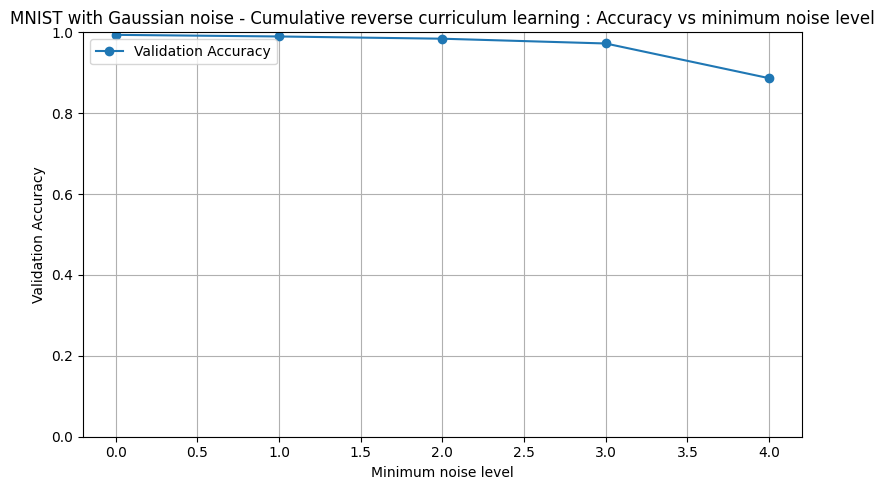

In [32]:
plot_validation_accuracy(
    min_noise_levels_MNIST_gaussian_cum_rev_curr_learn,
    stage_accs_MNIST_gaussian_cum_rev_curr_learn,
    x_label="Minimum noise level",
    title="MNIST with Gaussian noise - Cumulative reverse curriculum learning : Accuracy vs minimum noise level")

#### (4.2) Strict Reverse Curriculum Learning

In [33]:
stage_accs_MNIST_Gaussian_strict_rev_curr_learn = []
noise_levels_MNIST_Gaussian_strict_rev_curr_learn = []
num_examples_MNIST_Gaussian_strict_rev_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Gaussian_strict_rev_curr_learn.append(acc)
        noise_levels_MNIST_Gaussian_strict_rev_curr_learn.append(stage)
        num_examples_MNIST_Gaussian_strict_rev_curr_learn.append(len(X_stage))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.3086, Acc: 0.9029

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.0833, Acc: 0.9744

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0505, Acc: 0.9841

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0355, Acc: 0.9890

Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.0257, Acc: 0.9920

Final Test Accuracy: 0.9813


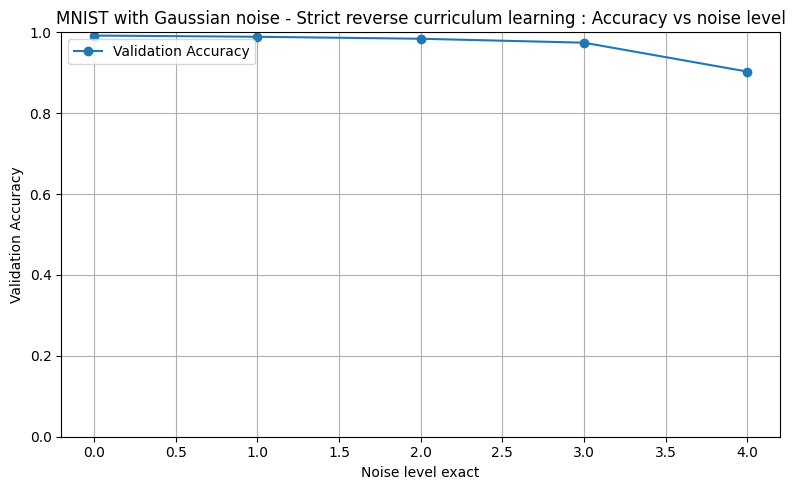

In [34]:
plot_validation_accuracy(
    noise_levels_MNIST_Gaussian_strict_rev_curr_learn,
    stage_accs_MNIST_Gaussian_strict_rev_curr_learn,
    x_label="Noise level exact",
    title="MNIST with Gaussian noise - Strict reverse curriculum learning : Accuracy vs noise level")

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [35]:
stage_accs_MNIST_Gaussian_Monte_Carlo = []
noise_levels_MNIST_Gaussian_Monte_Carlo = []
num_examples_MNIST_Gaussian_Monte_Carlo = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 1 
num_stages = 5
samples_per_stage = 10000

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Sampling from stage level = {stage}")
    
    stage_mask = (noise_levels_train == stage).nonzero(as_tuple=True)[0]
    
    # Randomly sample without replacement
    if len(stage_mask) < samples_per_stage:
        print(f"  Warning: only {len(stage_mask)} samples available, using all.")
        selected_indices = stage_mask
    else:
        selected_indices = stage_mask[torch.randperm(len(stage_mask))[:samples_per_stage]]
    
    X_stage = X_train[selected_indices]
    y_stage = y_train[selected_indices]
    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    predicted = outputs.argmax(dim=1)
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Gaussian_Monte_Carlo.append(acc)
        noise_levels_MNIST_Gaussian_Monte_Carlo.append(stage)
        num_examples_MNIST_Gaussian_Monte_Carlo.append(len(train_dataset))

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Stage 1/5: Sampling from stage level = 0
  Epoch 1/1 - Loss: 0.5565, Acc: 0.8302

Stage 2/5: Sampling from stage level = 1
  Epoch 1/1 - Loss: 0.1560, Acc: 0.9543

Stage 3/5: Sampling from stage level = 2
  Epoch 1/1 - Loss: 0.1206, Acc: 0.9623

Stage 4/5: Sampling from stage level = 3
  Epoch 1/1 - Loss: 0.1200, Acc: 0.9623

Stage 5/5: Sampling from stage level = 4
  Epoch 1/1 - Loss: 0.1510, Acc: 0.9508

Final Test Accuracy: 0.9731


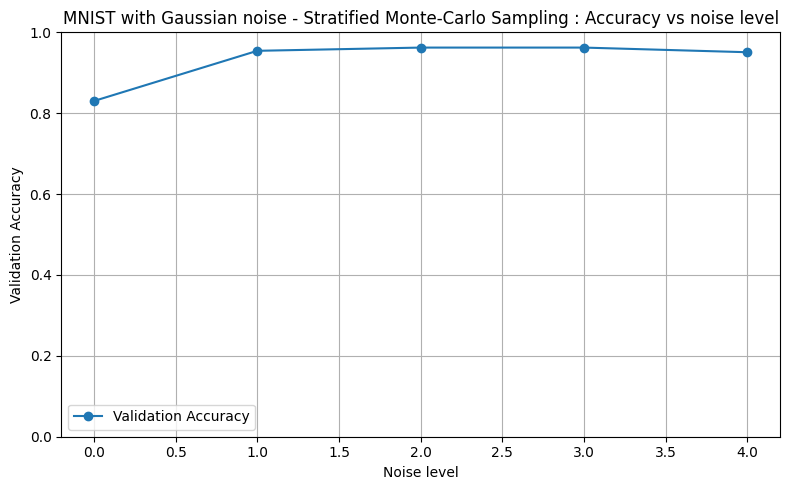

In [36]:
plot_validation_accuracy(
    noise_levels_MNIST_Gaussian_Monte_Carlo,
    stage_accs_MNIST_Gaussian_Monte_Carlo,
    x_label="Noise level",
    title="MNIST with Gaussian noise - Stratified Monte-Carlo Sampling : Accuracy vs noise level")


# MNIST Dataset with Impulse Noise

## Data Loading

We initialize a range of increasing difficulty. 
- 0.0: no noise — easiest samples
- 0.4: very noisy — hardest samples
- 0.5+ usually makes MNIST unreadable

In [37]:
base_train = datasets.MNIST(root='./data', train=True, download=True)
base_test = datasets.MNIST(root='./data', train=False, download=True)

full_data = torch.cat([base_train.data, base_test.data], dim=0).float() / 255.0
full_targets = torch.cat([base_train.targets, base_test.targets], dim=0)

noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]

augmented_data, augmented_targets, noise_labels = [], [], []

for level in noise_levels:
    noisy_data = full_data.clone()
    if level > 0:
        N, H, W = noisy_data.shape
        total_pixels = H * W

        num_noisy = int(level * total_pixels)

        for i in range(N):
            coords = torch.randperm(total_pixels)[:num_noisy]
            salt_or_pepper = torch.randint(0, 2, (num_noisy,), dtype=torch.float32)  # 0 or 1
            flat_image = noisy_data[i].view(-1)
            flat_image[coords] = salt_or_pepper

    augmented_data.append(noisy_data)
    augmented_targets.append(full_targets)
    noise_labels.append(torch.full_like(full_targets, fill_value=level))

augmented_data = torch.cat(augmented_data, dim=0).unsqueeze(1)
augmented_targets = torch.cat(augmented_targets, dim=0)
noise_labels = torch.cat(noise_labels, dim=0)

N_train = len(base_train)
N_test = len(base_test)
samples_per_level = N_train + N_test

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for i in range(len(noise_levels)):
    start = i * samples_per_level
    end = start + samples_per_level

    X_level = augmented_data[start:end]
    y_level = augmented_targets[start:end]

    X_train_list.append(X_level[:N_train])
    y_train_list.append(y_level[:N_train])
    X_test_list.append(X_level[N_train:])
    y_test_list.append(y_level[N_train:])

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

noise_levels_train_list = []

for i, level in enumerate(noise_levels):
    noise_level_tensor = torch.full((N_train,), fill_value=i)
    noise_levels_train_list.append(noise_level_tensor)

noise_levels_train = torch.cat(noise_levels_train_list, dim=0)
print(f"noise_levels_train shape: {noise_levels_train.shape}")


X_train: torch.Size([300000, 1, 28, 28]), y_train: torch.Size([300000])
X_test: torch.Size([50000, 1, 28, 28]), y_test: torch.Size([50000])
noise_levels_train shape: torch.Size([300000])


## Analysis

### (0) Base Case

In [38]:
# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # random sampling baseline
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f}, Train Acc: {train_acc:.4f}")

# Evaluate
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/1 - Train Loss: 0.1346, Train Acc: 0.9569
Test Accuracy: 0.9767


### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [39]:
stage_accs_MNIST_Impulse_cum_curr_learn = []
max_noise_levels_MNIST_Impulse_cum_curr_learn = []
num_examples_MNIST_Impulse_cum_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels <= {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train <= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Impulse_cum_curr_learn.append(acc)
        max_noise_levels_MNIST_Impulse_cum_curr_learn.append(stage)
        num_examples_MNIST_Impulse_cum_curr_learn.append(len(train_dataset))

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise levels <= 0
  Epoch 1/1 - Loss: 0.1830, Acc: 0.9435

Stage 2/5: Using noise levels <= 1
  Epoch 1/1 - Loss: 0.0571, Acc: 0.9823

Stage 3/5: Using noise levels <= 2
  Epoch 1/1 - Loss: 0.0406, Acc: 0.9867

Stage 4/5: Using noise levels <= 3
  Epoch 1/1 - Loss: 0.0396, Acc: 0.9867

Stage 5/5: Using noise levels <= 4
  Epoch 1/1 - Loss: 0.0468, Acc: 0.9844

Final Test Accuracy: 0.9765


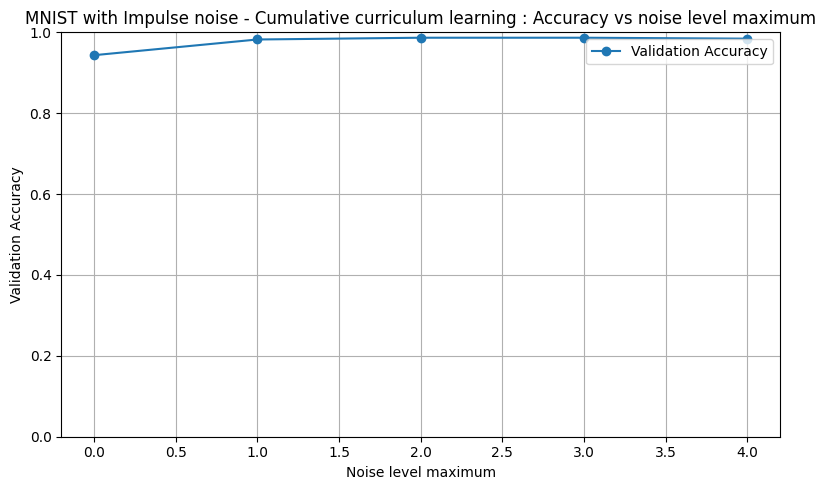

In [40]:
plot_validation_accuracy(
    max_noise_levels_MNIST_Impulse_cum_curr_learn,
    stage_accs_MNIST_Impulse_cum_curr_learn,
    x_label="Noise level maximum",
    title="MNIST with Impulse noise - Cumulative curriculum learning : Accuracy vs noise level maximum")


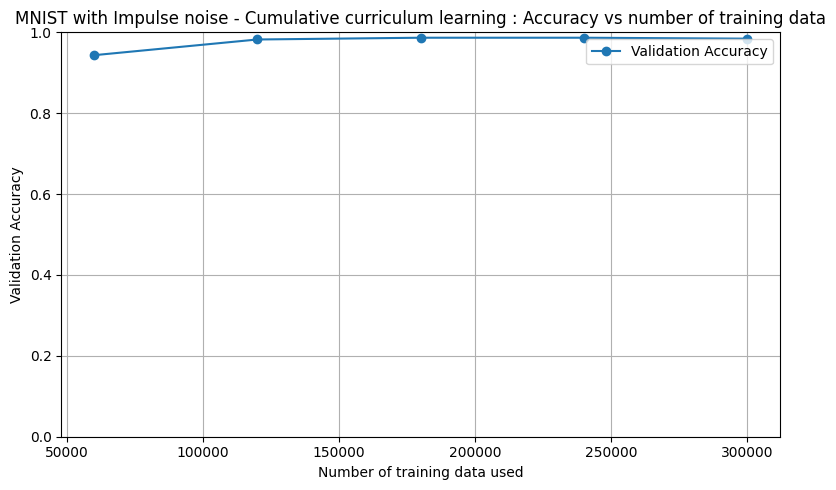

In [41]:
plot_validation_accuracy(
    num_examples_MNIST_Impulse_cum_curr_learn,
    stage_accs_MNIST_Impulse_cum_curr_learn,
    x_label="Number of training data used",
    title="MNIST with Impulse noise - Cumulative curriculum learning : Accuracy vs number of training data")


#### (1.2) Strict Curriculum Learning

In [42]:
stage_accs_MNIST_Impulse_strict_curr_learn = []
noise_levels_MNIST_Impulse_strict_curr_learn = []
num_examples_MNIST_Impulse_strict_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Impulse_strict_curr_learn.append(acc)
        noise_levels_MNIST_Impulse_strict_curr_learn.append(stage)
        num_examples_MNIST_Impulse_strict_curr_learn.append(len(train_dataset))

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.1687, Acc: 0.9474

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0739, Acc: 0.9769

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0784, Acc: 0.9752

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.1035, Acc: 0.9666

Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.1599, Acc: 0.9458

Final Test Accuracy: 0.9743


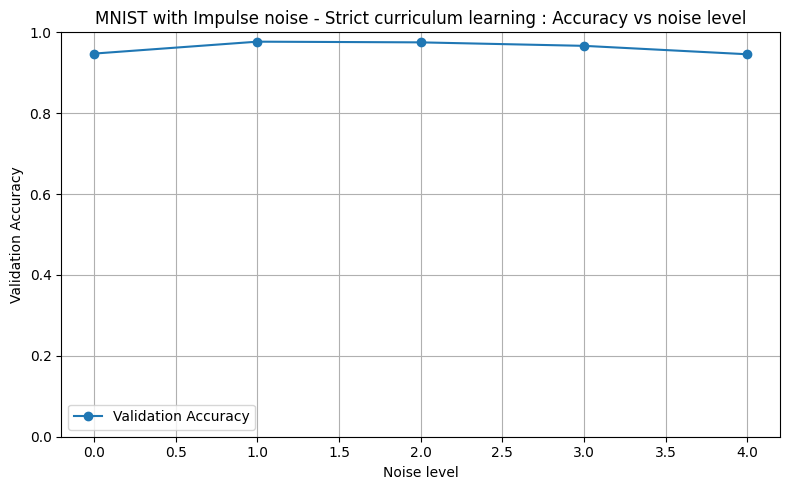

In [43]:
plot_validation_accuracy(
    noise_levels_MNIST_Impulse_strict_curr_learn,
    stage_accs_MNIST_Impulse_strict_curr_learn,
    x_label="Noise level",
    title="MNIST with Impulse noise - Strict curriculum learning : Accuracy vs noise level")

### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

Because our objective is to see the influence of order on the training, we will stop training once the model saw the entire dataset. To be fair with the other techniques where they see the data only once.

In [44]:
train_accs_MNIST_Impulse_self_paced = []
epochs_list_MNIST_Impulse_self_paced = []
num_selected_MNIST_Impulse_self_paced = []
lambda_values_MNIST_Impulse_self_paced = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Important: per-sample loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10
initial_lambda = 2.25  # initial difficulty threshold
lambda_increment = 2  # increase per epoch

# Wrap all training data in a dataset/loader for loss evaluation
full_train_dataset = TensorDataset(X_train, y_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.eval()
    all_losses = []

    # Compute per-sample losses on the full training set
    with torch.no_grad():
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)  # shape: (batch_size,)
            all_losses.append(losses.cpu())

    all_losses = torch.cat(all_losses)  # shape: (N,)
    print(torch.min(all_losses))
    print(torch.max(all_losses))

    # Determine current lambda threshold
    lambda_threshold = initial_lambda + epoch * lambda_increment

    # Select indices where loss <= lambda_threshold
    selected_indices = (all_losses <= lambda_threshold).nonzero(as_tuple=True)[0]

    if len(selected_indices) == 0:
        print(f"Epoch {epoch+1}: No samples selected for training (lambda={lambda_threshold:.3f}), stopping early.")
        break

    print(f"Epoch {epoch+1}: lambda={lambda_threshold:.3f}, selected {len(selected_indices)}/{len(X_train)} samples")

    # Create subset dataset and loader for training
    train_subset = TensorDataset(X_train[selected_indices], y_train[selected_indices])
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Train on selected samples
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()  # mean loss for batch
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_subset)

# VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total


    print(f"  Training Loss: {total_loss/len(train_subset):.4f}, Accuracy: {acc:.4f}")

    train_accs_MNIST_Impulse_self_paced.append(acc)
    epochs_list_MNIST_Impulse_self_paced.append(epoch + 1)
    num_selected_MNIST_Impulse_self_paced.append(len(selected_indices))
    lambda_values_MNIST_Impulse_self_paced.append(lambda_threshold)


    if len(selected_indices) == len(X_train):
        print(f"  All samples were selected, stopping early.")
        break

# Evaluate on test set after training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


tensor(2.1687)
tensor(2.4027)
Epoch 1: lambda=2.250, selected 36134/300000 samples
  Training Loss: 0.0547, Accuracy: 0.9865
tensor(-0.)
tensor(27.8123)
Epoch 2: lambda=4.250, selected 86550/300000 samples
  Training Loss: 0.0202, Accuracy: 0.9934
tensor(-0.)
tensor(45.7341)
Epoch 3: lambda=6.250, selected 91262/300000 samples
  Training Loss: 0.0193, Accuracy: 0.9936
tensor(-0.)
tensor(49.6799)
Epoch 4: lambda=8.250, selected 141022/300000 samples
  Training Loss: 0.0468, Accuracy: 0.9852
tensor(-0.)
tensor(41.8776)
Epoch 5: lambda=10.250, selected 282805/300000 samples
  Training Loss: 0.0631, Accuracy: 0.9788
tensor(-0.)
tensor(32.8707)
Epoch 6: lambda=12.250, selected 299928/300000 samples
  Training Loss: 0.0496, Accuracy: 0.9836
tensor(-0.)
tensor(29.9876)
Epoch 7: lambda=14.250, selected 299990/300000 samples
  Training Loss: 0.0340, Accuracy: 0.9885
tensor(-0.)
tensor(29.2927)
Epoch 8: lambda=16.250, selected 299995/300000 samples
  Training Loss: 0.0244, Accuracy: 0.9916
tenso

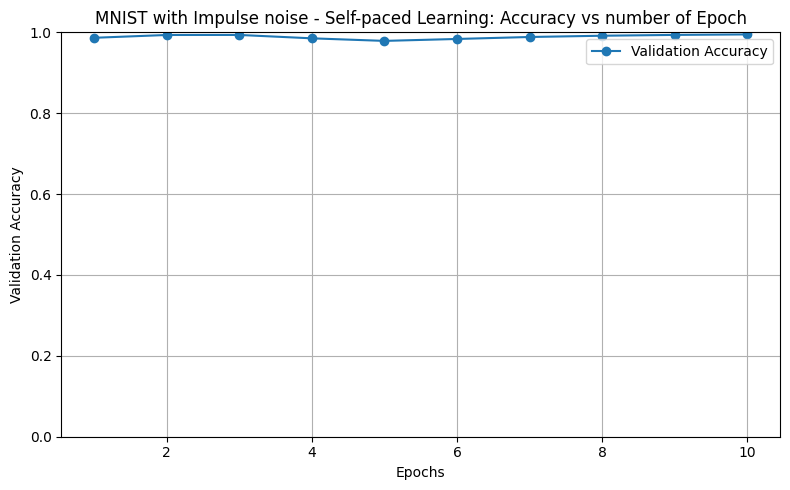

In [45]:
plot_validation_accuracy(
    epochs_list_MNIST_Impulse_self_paced,
    train_accs_MNIST_Impulse_self_paced,
    x_label="Epochs",
    title="MNIST with Impulse noise - Self-paced Learning: Accuracy vs number of Epoch")

An idea could be to combine the difficulty scores from the noise levels with the increments in SLP:


**Option A: Use Noise Difficulty as a Prior or Weight for Lambda Threshold**

- Adjust the SPL threshold (`λ`) for each sample by incorporating its noise difficulty:

\[
\lambda_i = \lambda_{\text{base}} + \alpha \times \text{noise\_level}_i
\]

- Samples with higher noise difficulty require a higher loss to be included, effectively entering the curriculum later.

**Option B: Use Noise Difficulty for Initial Sample Filtering**

- Start SPL training using only samples with noise difficulty below a certain threshold (e.g., noise_level ≤ 0.2).
- Gradually expand the training set to include samples with higher noise difficulty as training progresses.

**Option C: Weighted Loss or Thresholding by Noise Difficulty Quantiles**

- Group samples by their noise difficulty levels.
- Compute separate SPL loss thresholds for each noise group.
- Allow lower thresholds (easier inclusion) for low-noise groups and higher thresholds for high-noise groups.
- This respects both the *a priori* noise difficulty and the *dynamic* training loss.

### (3) Hard-Example Mining

In [46]:
train_accs_MNIST_Impulse_H_Ex = []
epochs_list_MNIST_Impulse_H_Ex = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 5

# Define what "hard" means: top 1 or 2 noise levels (e.g., 0.3 and 0.4)
# If noise_levels_train goes from 0 to 4 (for noise 0.0 to 0.4), we can take levels >= 3
hard_mask = noise_levels_train >= 3

# Select hard examples
X_hard = X_train[hard_mask]
y_hard = y_train[hard_mask]
print(f"Selected {len(X_hard)} hard examples out of {len(X_train)}")

# Wrap in dataset and loader
hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

# Training loop on hard examples
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)

# VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               outputs = model(images)
               predicted = outputs.argmax(dim=1)
               val_correct += (predicted == labels).sum().item()
               val_total += labels.size(0)

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(hard_dataset):.4f}, Accuracy: {acc:.4f}")

    train_accs_MNIST_Impulse_H_Ex.append(acc)
    epochs_list_MNIST_Impulse_H_Ex.append(epoch + 1)

# Final test evaluation
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Selected 120000 hard examples out of 300000
Epoch 1/5 - Loss: 0.2869, Accuracy: 0.9084
Epoch 2/5 - Loss: 0.1265, Accuracy: 0.9586
Epoch 3/5 - Loss: 0.0927, Accuracy: 0.9692
Epoch 4/5 - Loss: 0.0713, Accuracy: 0.9757
Epoch 5/5 - Loss: 0.0543, Accuracy: 0.9814

Final Test Accuracy: 0.9781


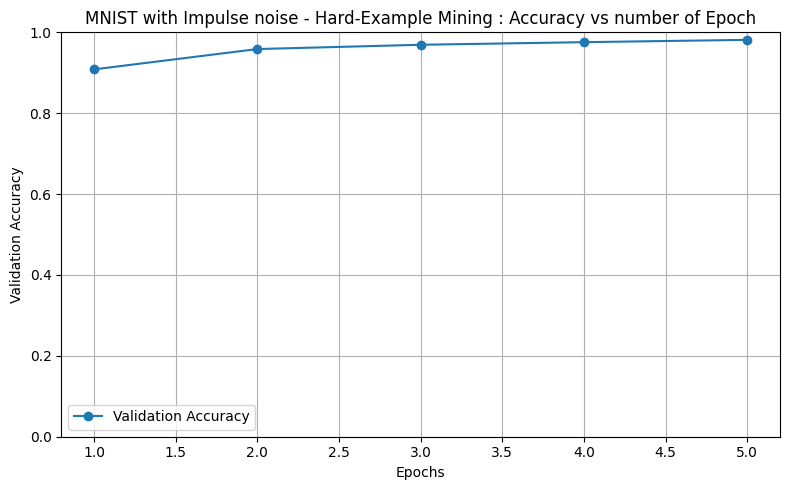

In [47]:
plot_validation_accuracy(
    epochs_list_MNIST_Impulse_H_Ex,
    train_accs_MNIST_Impulse_H_Ex,
    x_label="Epochs",
    title="MNIST with Impulse noise - Hard-Example Mining : Accuracy vs number of Epoch")

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [48]:
stage_accs_MNIST_Impulse_cum_rev_curr_learn = []
min_noise_levels_MNIST_Impulse_cum_rev_curr_learn = []
num_examples_MNIST_Impulse_cum_rev_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels >= {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train >= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total


        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Impulse_cum_rev_curr_learn.append(acc)
        min_noise_levels_MNIST_Impulse_cum_rev_curr_learn.append(stage)
        num_examples_MNIST_Impulse_cum_rev_curr_learn.append(len(train_dataset))

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise levels >= 4
  Epoch 1/1 - Loss: 0.5477, Acc: 0.8209

Stage 4/5: Using noise levels >= 3
  Epoch 1/1 - Loss: 0.1787, Acc: 0.9428

Stage 3/5: Using noise levels >= 2
  Epoch 1/1 - Loss: 0.1080, Acc: 0.9647

Stage 2/5: Using noise levels >= 1
  Epoch 1/1 - Loss: 0.0726, Acc: 0.9761

Stage 1/5: Using noise levels >= 0
  Epoch 1/1 - Loss: 0.0512, Acc: 0.9830

Final Test Accuracy: 0.9765


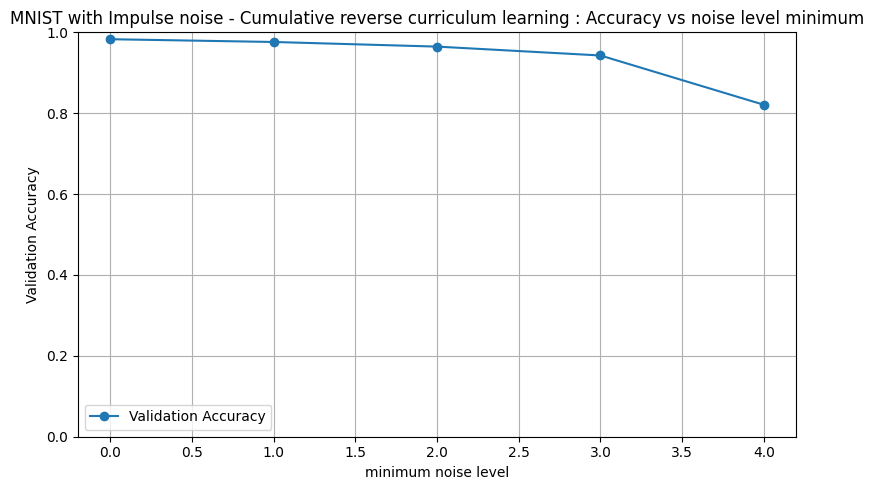

In [49]:
plot_validation_accuracy(
    min_noise_levels_MNIST_Impulse_cum_rev_curr_learn,
    stage_accs_MNIST_Impulse_cum_rev_curr_learn,
    x_label="minimum noise level",
    title="MNIST with Impulse noise - Cumulative reverse curriculum learning : Accuracy vs noise level minimum")

#### (4.2) Strict Reverse Curriculum Learning

In [50]:
stage_accs_MNIST_Impulse_Strict_rev_curr_learn = []
noise_levels_MNIST_Impulse_Strict_rev_curr_learn = []
num_examples_MNIST_Impulse_Strict_rev_curr_learn = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

    # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Impulse_Strict_rev_curr_learn.append(acc)
        noise_levels_MNIST_Impulse_Strict_rev_curr_learn.append(stage)
        num_examples_MNIST_Impulse_Strict_rev_curr_learn.append(len(train_dataset))


# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.4414, Acc: 0.8561

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.1362, Acc: 0.9575

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0749, Acc: 0.9760

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0468, Acc: 0.9852

Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.0318, Acc: 0.9898

Final Test Accuracy: 0.9444


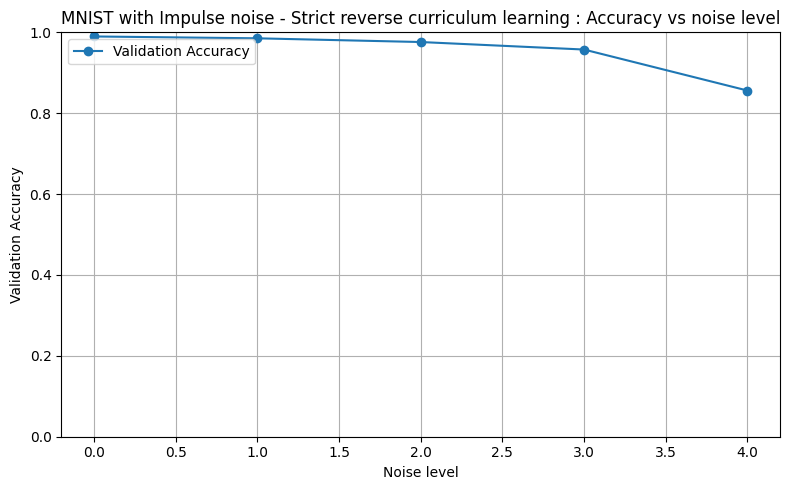

In [51]:
plot_validation_accuracy(
    noise_levels_MNIST_Impulse_Strict_rev_curr_learn,
    stage_accs_MNIST_Impulse_Strict_rev_curr_learn,
    x_label="Noise level",
    title="MNIST with Impulse noise - Strict reverse curriculum learning : Accuracy vs noise level")


### (5) Stratified Monte-Carlo Sampling

In [52]:
stage_accs_MNIST_Impulse_Monte_Carlo = []
noise_levels_MNIST_Impulse_Monte_Carlo = []
num_examples_MNIST_Impulse_Monte_Carlo = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # same as curriculum
num_stages = 5        # noise levels 0–4
samples_per_stage = 10000  # number of examples to sample from each difficulty level

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Sampling from noise level = {stage}")
    
    # Select indices for current noise level
    stage_mask = (noise_levels_train == stage).nonzero(as_tuple=True)[0]
    
    # Randomly sample without replacement
    if len(stage_mask) < samples_per_stage:
        print(f"  Warning: only {len(stage_mask)} samples available, using all.")
        selected_indices = stage_mask
    else:
        selected_indices = stage_mask[torch.randperm(len(stage_mask))[:samples_per_stage]]
    
    # Prepare subset
    X_stage = X_train[selected_indices]
    y_stage = y_train[selected_indices]
    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)

    # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total

        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

        stage_accs_MNIST_Impulse_Monte_Carlo.append(acc)
        noise_levels_MNIST_Impulse_Monte_Carlo.append(stage)
        num_examples_MNIST_Impulse_Monte_Carlo.append(len(train_dataset))


# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Stage 1/5: Sampling from noise level = 0
  Epoch 1/1 - Loss: 0.5676, Acc: 0.8255

Stage 2/5: Sampling from noise level = 1
  Epoch 1/1 - Loss: 0.2062, Acc: 0.9370

Stage 3/5: Sampling from noise level = 2
  Epoch 1/1 - Loss: 0.1723, Acc: 0.9442

Stage 4/5: Sampling from noise level = 3
  Epoch 1/1 - Loss: 0.2090, Acc: 0.9332

Stage 5/5: Sampling from noise level = 4
  Epoch 1/1 - Loss: 0.2476, Acc: 0.9172

Final Test Accuracy: 0.9561


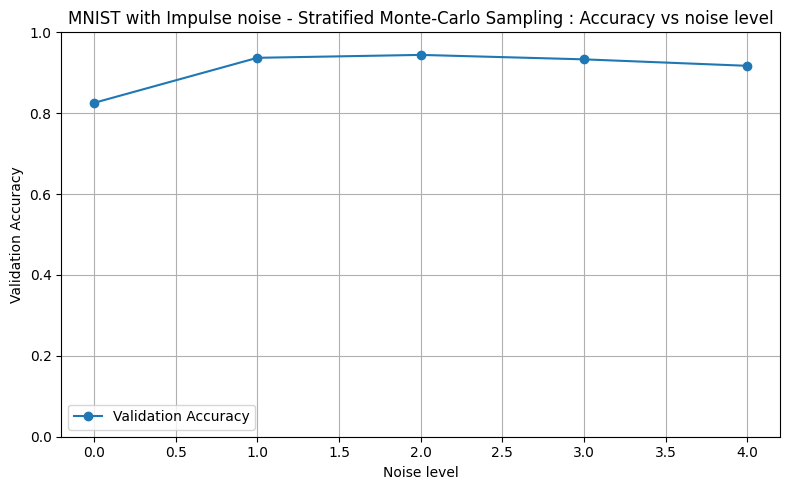

In [53]:
plot_validation_accuracy(
    noise_levels_MNIST_Impulse_Monte_Carlo,
    stage_accs_MNIST_Impulse_Monte_Carlo,
    x_label="Noise level",
    title="MNIST with Impulse noise - Stratified Monte-Carlo Sampling : Accuracy vs noise level")


# Final Results

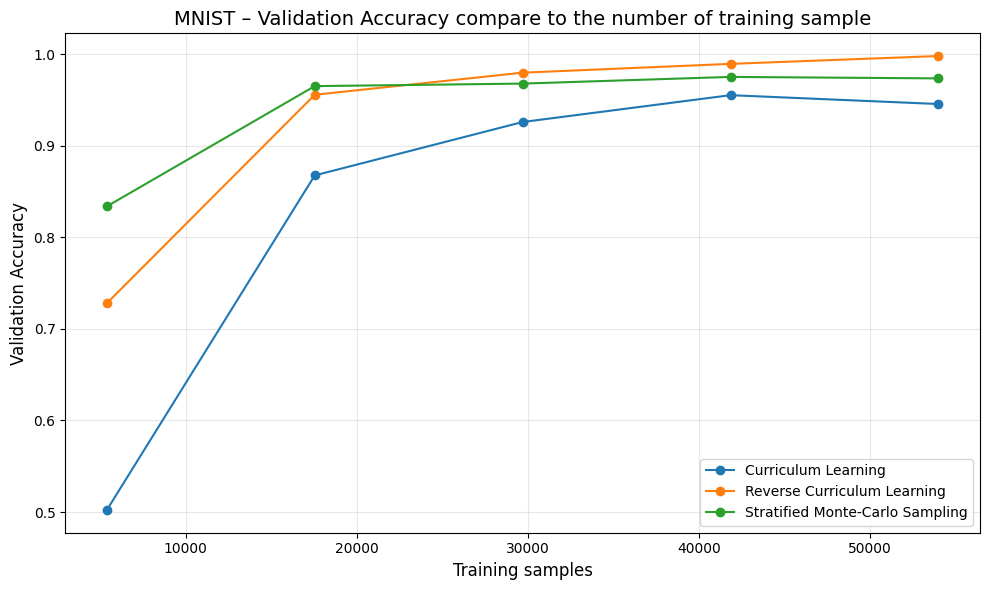

In [60]:
plot_multi_curves(
    num_examples_MNIST_curr_learn,
    stage_accs_MNIST_curr_learn,
    stage_accs_MNIST_Rev_Curr_learn,
    stage_accs_MNIST_Monte_Carlo,
    labels=[
        "Curriculum Learning",
        "Reverse Curriculum Learning",
        "Stratified Monte-Carlo Sampling"
    ],
    title="MNIST – Validation Accuracy compare to the number of training sample",
    xlabel="Training samples",
    ylabel="Validation Accuracy",
    markers=["o", "o", "o"],
    linestyles=["-", "-", "-"],
)